In [1]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GCNConv



In [2]:
import sys, torch

print("exe:", sys.executable)
print("torch:", torch.__version__)
print("cuda build:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

exe: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Scripts\python.exe
torch: 2.5.1+cu121
cuda build: 12.1
cuda available: True
gpu: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
import sys, os, torch, site, pkgutil, importlib
print("exe:", sys.executable)
print("torch version:", torch.__version__)
print("torch file:", torch.__file__)
print("PYTORCH_FORCE_CPU:", os.environ.get("PYTORCH_FORCE_CPU"))
print("site-packages:", site.getsitepackages())
print("user site:", site.getusersitepackages())
#print(sys.path)  # uncomment if needed


exe: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Scripts\python.exe
torch version: 2.5.1+cu121
torch file: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\torch\__init__.py
PYTORCH_FORCE_CPU: None
site-packages: ['C:\\Users\\Alice\\PycharmProjects\\co-simulation-code\\.venv1', 'C:\\Users\\Alice\\PycharmProjects\\co-simulation-code\\.venv1\\Lib\\site-packages']
user site: C:\Users\Alice\AppData\Roaming\Python\Python311\site-packages


In [4]:
import sys; print(sys.version)


3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [5]:
import pandas as pd

test_df  = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")


In [6]:
# Your edge feature columns (adjust if you want more/less)
EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target'   # binary {0,1}

# Time encoding (periods in seconds)
def time_posenc(t, periods=(60, 300, 3600)):
    # t: numpy array of epoch seconds
    feats = []
    for P in periods:
        w = 2*math.pi/P
        feats.append(np.sin(w*t))
        feats.append(np.cos(w*t))
    return np.stack(feats, axis=1)  # [N, 2*len(periods)]

In [7]:
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import numpy as np
from typing import DefaultDict
# ← add this where build_snapshots is defined (same file)
# (If you only call build_snapshots, add it at the top of that module/notebook cell.)

def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu'):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    # Stable node indexing across all snapshots in this split
    ips = pd.Index(pd.unique(pd.concat([df['Src IP'], df['Dst IP']])))
    ip2idx = {ip:i for i,ip in enumerate(ips)}

    snapshots = []
    # For 1-bin lag activity: track per-node edge count in previous bin
    prev_activity = defaultdict(int)

    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        edge_attr = torch.tensor(np.hstack([eX, tfe]), dtype=torch.float)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features (inductive, not learned):
        #   in/out/total degree in THIS snapshot + previous-bin activity count
        n_nodes = len(ip2idx)
        out_deg = np.bincount(src, minlength=n_nodes)
        in_deg  = np.bincount(dst, minlength=n_nodes)
        deg     = (out_deg + in_deg).reshape(-1,1)
        node_feat = np.hstack([
            in_deg.reshape(-1,1),
            out_deg.reshape(-1,1),
            deg,
            np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
        ])
        # log1p to compress scale
        node_feat = np.log1p(node_feat)
        x = torch.tensor(node_feat, dtype=torch.float)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        # Store mapping to recover edge order if needed
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Move to device lazily in loader/training
    return snapshots, ip2idx, scaler_edge, edge_cols + [f'time_{i}' for i in range(tfe.shape[1])]

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, LayerNorm

class GraphTimeEdgeClassifier(nn.Module):
    def __init__(self, in_node, in_edge, hidden=64, gnn='sage',
                 num_layers=2, dropout=0.2, gat_heads=4,
                 use_edge_attr_in_gat=True, pair_mode='concat'):
        """
        gnn: 'gcn' | 'sage' | 'gat'
        pair_mode: 'concat' (h_i || h_j), 'concat+diff+had' (richer), or 'had' (h_i * h_j)
        """
        super().__init__()
        self.gnn = gnn
        self.dropout = nn.Dropout(dropout)
        self.pair_mode = pair_mode
        self.hidden = hidden
        self.in_edge = in_edge
        self.gat_heads = gat_heads
        self.use_edge_attr_in_gat = use_edge_attr_in_gat

        # --- conv factory
        def make_conv(i, o):
            if gnn == 'gcn':
                return GCNConv(i, o, normalize=True)
            elif gnn == 'sage':
                return SAGEConv(i, o)
            elif gnn == 'gat':
                # keep output dim = hidden by concatenating heads
                out_per_head = o // gat_heads
                assert o % gat_heads == 0, "hidden must be divisible by gat_heads"
                return GATv2Conv(
                    in_channels=i,
                    out_channels=out_per_head,
                    heads=gat_heads,
                    concat=True,
                    edge_dim=(in_edge if use_edge_attr_in_gat else None)
                )
            else:
                raise ValueError("gnn must be 'gcn', 'sage', or 'gat'")

        # --- layers
        dims = [in_node] + [hidden] * num_layers
        self.convs = nn.ModuleList([make_conv(dims[i], dims[i+1]) for i in range(num_layers)])
        self.norms = nn.ModuleList([LayerNorm(hidden) for _ in range(num_layers)])

        # --- edge head input dim based on pairing
        if pair_mode == 'concat':
            edge_in = 2*hidden + in_edge
        elif pair_mode == 'concat+diff+had':
            edge_in = (2*hidden + hidden + hidden) + in_edge  # h_i||h_j||(h_i-h_j)||(h_i*h_j)
        elif pair_mode == 'had':
            edge_in = hidden + in_edge                        # (h_i*h_j)||edge_attr
        else:
            raise ValueError("pair_mode not recognized")

        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    def node_encode(self, x, edge_index, edge_attr):
        for l, conv in enumerate(self.convs):
            h_in = x
            if self.gnn == 'gat':
                x = conv(x, edge_index, edge_attr=edge_attr if self.use_edge_attr_in_gat else None)
            else:
                x = conv(x, edge_index)
            x = self.norms[l](x)
            x = F.relu(x)
            x = self.dropout(x)
            # simple residual if dims match
            if h_in.shape == x.shape:
                x = x + h_in
        return x  # [N, hidden]

    def pair_edges(self, x, edge_index, edge_attr):
        src, dst = edge_index
        h_i, h_j = x[src], x[dst]          # [E, hidden], [E, hidden]
        if self.pair_mode == 'concat':
            z = torch.cat([h_i, h_j, edge_attr], dim=1)
        elif self.pair_mode == 'concat+diff+had':
            z = torch.cat([h_i, h_j, h_i - h_j, h_i * h_j, edge_attr], dim=1)
        else:  # 'had'
            z = torch.cat([h_i * h_j, edge_attr], dim=1)
        return z

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.node_encode(x, edge_index, edge_attr)          # [N, hidden]
        z = self.pair_edges(x, edge_index, edge_attr)           # [E, ...]
        logits = self.edge_mlp(z)                               # [E, 2]
        return logits


In [9]:
def run_epoch(model, snapshots, optimizer=None, device='cpu', weights=None):
    is_train = optimizer is not None
    total_loss, total_correct, total_edges = 0.0, 0, 0
    ce = nn.CrossEntropyLoss(weight=weights)   # <--- use weights

    for data in snapshots:
        data = data.to(device)
        logits = model(data)
        if is_train:
            loss = ce(logits, data.y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * data.y.numel()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            total_correct += int((pred == data.y).sum())
            total_edges += int(data.y.numel())

    avg_loss = total_loss / max(1, total_edges) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc


In [11]:

test_df  = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [11]:

import torch
print("torch:", torch.__version__)
print("cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())


torch: 2.5.1+cu121
cuda: 12.1
cuda available: True


In [12]:
# Assume you already have train_df and test_df with the listed columns
# Build train snapshots (fit scaler)
import numpy as np

train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device
)

# Build test snapshots (reuse scaler; allow different IP set)
# To preserve strict inductive setting, we build a separate ip2idx for test (no shared node IDs).
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device
)



In [15]:
# --- imports you need ---
import torch, numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score

# ---------- weights from class imbalance ----------
def class_weights_from_snaps(snaps, device="cpu"):
    """
    Returns a tensor([w0, w1]) so positives are up-weighted:
    w1 = (#negatives / #positives). Safe if no positives.
    """
    neg = pos = 0
    for d in snaps:
        y = d.y
        neg += int((y == 0).sum())
        pos += int((y == 1).sum())
    w1 = (neg / max(1, pos)) if pos > 0 else 1.0
    return torch.tensor([1.0, float(w1)], dtype=torch.float32, device=device)

# ---------- quick PR-AUC evaluator (used by early stopping) ----------
@torch.no_grad()
def _pr_auc(model, snaps, device="cpu"):
    model.eval()
    ys, ps = [], []
    for d in snaps:
        y = d.y
        if not ((y == 0).any() and (y == 1).any()):   # skip single-class snapshots
            continue
        d = d.to(device)
        p1 = torch.softmax(model(d), dim=1)[:, 1].cpu().numpy()
        ys.append(y.cpu().numpy()); ps.append(p1)
    if not ys:
        return float("nan")
    y = np.concatenate(ys); p = np.concatenate(ps)
    return average_precision_score(y, p)

# ---------- training loop with early stopping on PR-AUC ----------
def train_one(model, snaps_train, snaps_val, device="cpu",
              lr=1e-3, wd=1e-5, epochs=10, patience=2,
              weights=None, grad_clip=0.5):
    """
    Trains `model` on a list of PyG Data snapshots.
    Early-stops by PR-AUC on `snaps_val`. Returns the best PR-AUC.
    """
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    ce  = torch.nn.CrossEntropyLoss(weight=weights)

    best, best_state, wait = -1.0, None, 0
    for _ in range(epochs):
        model.train()
        for d in snaps_train:
            d = d.to(device, non_blocking=True)
            loss = ce(model(d), d.y)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()

        pr = _pr_auc(model, snaps_val, device)
        if pr > best:
            best, best_state, wait = pr, {k: v.detach().cpu() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return best


In [16]:
# ---------- SPEED & MEMORY KNOBS ----------
FAST = True

if FAST:
    N_TRIALS          = 6
    N_SPLITS          = 2
    EPOCHS            = 3
    PATIENCE          = 1
    MAX_EDGES         = 3_000   # <- keep comment on same line to avoid indent issues
    NEG_FRAC          = 0.2
    TRAIN_MAX_SNAPS   = 30      # limit # of snapshots per fold
    VAL_MAX_SNAPS     = 12
    BINS_STRIDE       = 2       # use every 2nd bin during tuning
else:
    N_TRIALS          = 25
    N_SPLITS          = 5
    EPOCHS            = 10
    PATIENCE          = 2
    MAX_EDGES         = 20_000
    NEG_FRAC          = 0.5
    TRAIN_MAX_SNAPS   = 99999
    VAL_MAX_SNAPS     = 99999
    BINS_STRIDE       = 1

# ---------- PREP: keep minimal columns + downcast to float32 ----------
import gc, pandas as pd, numpy as np, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def _minimal(df: pd.DataFrame) -> pd.DataFrame:
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols = [c for c in (ID_COLS + edge_cols + [LABEL_COL]) if c in df.columns]
    out = df[cols].copy()

    # downcast floats to float32 to halve memory
    for c in edge_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce").astype(np.float32)
    return out

BIN_SECS = 300

train_min = _minimal(train_df)
test_min  = _minimal(test_df)

train_binned = bin_time(train_min, BIN_SECS).sort_values('_bin')
test_binned  = bin_time(test_min,  BIN_SECS).sort_values('_bin')

train_bins_all = train_binned['_bin'].unique()
test_bins_all  = test_binned['_bin'].unique()

def df_from_bins_prebinned(df_binned: pd.DataFrame, bins_sel):
    # select rows for bins_sel; no extra column drops (build_snapshots selects what it needs)
    return df_binned[df_binned['_bin'].isin(set(bins_sel))]

def make_snaps_for_bins(df_binned, bins_sel, scaler_edge=None, fit=False, device="cpu"):
    sub_df = df_from_bins_prebinned(df_binned, bins_sel)
    snaps, _, scaler, _ = build_snapshots(
        sub_df, scaler_edge=scaler_edge, fit_scaler=fit, bin_seconds=BIN_SECS, device=device
    )
    return snaps, scaler

# ---------- UTIL: stratified edge sampler & snapshot cap ----------
import torch
def sample_edges_stratified(data, pos_frac=1.0, neg_frac=0.2, max_edges=None):
    y = data.y
    pos = torch.nonzero(y == 1).view(-1)
    neg = torch.nonzero(y == 0).view(-1)
    kpos = len(pos) if pos_frac >= 1 else max(1, int(len(pos)*pos_frac)) if len(pos)>0 else 0
    kneg = len(neg) if neg_frac >= 1 else max(1, int(len(neg)*neg_frac)) if len(neg)>0 else 0
    keep = torch.cat([
        pos[torch.randperm(len(pos))[:kpos]] if len(pos)>0 else pos,
        neg[torch.randperm(len(neg))[:kneg]] if len(neg)>0 else neg
    ])
    if keep.numel() == 0: return data
    if max_edges is not None and keep.numel() > max_edges:
        keep = keep[torch.randperm(keep.numel())[:max_edges]]

    d = data.clone()
    d.edge_index = d.edge_index[:, keep]
    if getattr(d, "edge_attr", None) is not None:
        d.edge_attr = d.edge_attr[keep]
    d.y = d.y[keep]
    return d

def has_both_classes(d) -> bool:
    y = d.y.view(-1)
    return bool((y == 0).any().item() and (y == 1).any().item())

def cap_snaps(snaps, k):
    return snaps[:k] if (k is not None and len(snaps) > k) else snaps

# ---------- OPTUNA OBJECTIVE (memory-savvy) ----------
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    print(f"[optuna] trial {trial.number} start", flush=True)

    gnn        = trial.suggest_categorical("gnn", ["sage","gcn","gat"])
    hidden     = trial.suggest_categorical("hidden", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 2, 3)
    dropout    = trial.suggest_float("dropout", 0.1, 0.4)
    lr         = trial.suggest_float("lr", 5e-4, 2e-3, log=True)
    wd         = trial.suggest_float("weight_decay", 1e-8, 1e-4, log=True)
    gat_heads  = trial.suggest_categorical("gat_heads", [2,4]) if gnn == "gat" else 2
    pair_mode  = "concat"

    bins = train_bins_all[::BINS_STRIDE]  # stride bins for speed
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)

    scores = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(range(len(bins)))):
        train_bins = bins[tr_idx];  val_bins = bins[va_idx]

        tr_snaps, scaler_edge = make_snaps_for_bins(train_binned, train_bins, scaler_edge=None, fit=True, device=device)
        va_snaps, _           = make_snaps_for_bins(train_binned, val_bins,   scaler_edge=scaler_edge, fit=False, device=device)

        # limit snapshots per fold (controls RAM)
        tr_snaps = cap_snaps(tr_snaps, TRAIN_MAX_SNAPS)
        va_snaps = cap_snaps(va_snaps, VAL_MAX_SNAPS)

        # subsample edges
        tr_snaps = [sample_edges_stratified(d, pos_frac=1.0, neg_frac=NEG_FRAC, max_edges=MAX_EDGES) for d in tr_snaps]
        va_snaps = [sample_edges_stratified(d, pos_frac=1.0, neg_frac=NEG_FRAC, max_edges=MAX_EDGES) for d in va_snaps]

        # keep only valid val snapshots
        va_snaps = [d for d in va_snaps if has_both_classes(d)]
        if not va_snaps or not tr_snaps:
            # free memory before continuing
            del tr_snaps, va_snaps; gc.collect()
            continue

        in_node = tr_snaps[0].x.size(1)
        in_edge = tr_snaps[0].edge_attr.size(1)
        weights = class_weights_from_snaps(tr_snaps, device)

        model = GraphTimeEdgeClassifier(
            in_node=in_node, in_edge=in_edge, hidden=hidden, gnn=gnn,
            num_layers=num_layers, dropout=dropout, gat_heads=gat_heads,
            use_edge_attr_in_gat=True, pair_mode=pair_mode
        ).to(device)

        score = train_one(model, tr_snaps, va_snaps, device,
                          lr=lr, wd=wd, epochs=EPOCHS, patience=PATIENCE, weights=weights)
        if not np.isnan(score):
            scores.append(score)

        # free memory aggressively
        del model, tr_snaps, va_snaps, weights, scaler_edge
        if device == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

        trial.report(float(np.mean(scores)) if scores else -1.0, step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(scores)) if scores else float("-inf")


In [17]:
pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=N_SPLITS, reduction_factor=3)
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42),
                            pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print("BEST:", study.best_trial.params, "score:", study.best_trial.value)


  0%|          | 0/6 [00:00<?, ?it/s]

[optuna] trial 0 start
[optuna] trial 1 start
[optuna] trial 2 start
[optuna] trial 3 start
[optuna] trial 4 start
[optuna] trial 5 start
BEST: {'gnn': 'gcn', 'hidden': 32, 'num_layers': 2, 'dropout': 0.3598528437324806, 'lr': 0.0011504753106625046, 'weight_decay': 6.7965780907581515e-06} score: -inf


In [19]:
# Model dims
in_node = train_snaps[0].x.size(1)             # [in_deg, out_deg, deg, prev_activity] -> 4
in_edge = train_snaps[0].edge_attr.size(1)     # len(EDGE_COLS_kept) + time_posenc
model = GraphTimeEdgeClassifier( in_node, in_edge, hidden=32, gnn='gcn',
                 num_layers=2, dropout=0.3598528437324806, gat_heads=4,
                 use_edge_attr_in_gat=True, pair_mode='concat').to(device)

opt = torch.optim.AdamW(model.parameters(), lr=0.0011504753106625046, weight_decay=6.7965780907581515e-06)

EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_snaps, optimizer=opt, device=device)
    _, te_acc = run_epoch(model, test_snaps, optimizer=None, device=device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | train acc {tr_acc:.4f} | test acc {te_acc:.4f}")

Epoch 01 | train loss 6.4491 | train acc 0.8976 | test acc 0.8394
Epoch 02 | train loss 0.2408 | train acc 0.9642 | test acc 0.9303
Epoch 03 | train loss 0.0078 | train acc 0.9976 | test acc 0.9776
Epoch 04 | train loss 0.0073 | train acc 0.9969 | test acc 0.9947
Epoch 05 | train loss 0.0075 | train acc 0.9983 | test acc 0.9989


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_with_confusion(model, snapshots, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            logits = model(data)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("📊 Classification Report:")
    print(report)

    return cm, report

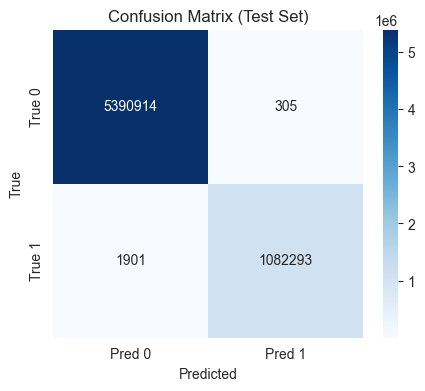

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998   5391219
           1     0.9997    0.9982    0.9990   1084194

    accuracy                         0.9997   6475413
   macro avg     0.9997    0.9991    0.9994   6475413
weighted avg     0.9997    0.9997    0.9997   6475413



In [21]:
cm, report = evaluate_with_confusion(model, test_snaps, device=device)
